In [ ]:
!pip install tweet_preprocessor
!pip install pyLDAvis
import nltk
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
!pip install twython

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import re
import preprocessor as p
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim import matutils
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import pyLDAvis.gensim

warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
tweet_data = pd.read_csv('/content/drive/My Drive/tweet_data/COVID19 India Tweets.csv',encoding='utf-8')

In [7]:
tweet_data = tweet_data.drop_duplicates(subset=['username','text'],keep='first').reset_index(drop=True)

In [8]:
tweet_data['created_at'] = pd.to_datetime(tweet_data['created_at'],format='%d/%m/%y %H:%M')
tweet_data.sort_values(by='created_at',ignore_index=True,inplace=True)

## Data Description

In [9]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158028 entries, 0 to 158027
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   city          158028 non-null  object        
 1   country       158028 non-null  object        
 2   created_at    158028 non-null  datetime64[ns]
 3   followers     158028 non-null  int64         
 4   following     158028 non-null  int64         
 5   likes         158028 non-null  int64         
 6   name          158028 non-null  object        
 7   status_count  158028 non-null  int64         
 8   text          158028 non-null  object        
 9   tweet_id      158028 non-null  float64       
 10  username      158028 non-null  object        
 11  verified      158028 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 14.5+ MB


In [10]:
first_tweet_time = tweet_data['created_at'].min()
last_tweet_time = tweet_data['created_at'].max()
users = tweet_data['username'].nunique()
verified_users = tweet_data[tweet_data['verified']=='Verified']['username'].nunique()
non_verified_users = tweet_data[tweet_data['verified']=='Not verified']['username'].nunique()

print("First Tweet time: ",first_tweet_time)
print("Last Tweet time: ",last_tweet_time)
print("\nTotal Number of Users: ",users)
print("Number of verfied users: ", verified_users)
print("Number of non-verfied users: ", non_verified_users)

First Tweet time:  2020-03-25 06:02:00
Last Tweet time:  2020-09-15 04:24:00

Total Number of Users:  59784
Number of verfied users:  4557
Number of non-verfied users:  55227


## Data Cleaning and Pre-processing

### Cleaning the URLs, smileys, @mentions etc.

In [11]:
for i,v in enumerate(tweet_data['text']):
    tweet_data.loc[i,'clean_text'] = p.clean(v)

### Segregating #Hashtags

In [12]:
tweet_data['hashtag'] = tweet_data['text'].apply(lambda x: re.findall(r"#(\w+)", x))

### Pre-processing of tweets

In [13]:
def preprocess_tweets(data):
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = WordNetLemmatizer()
    w_tokkenizer = TweetTokenizer()
    
    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokkenizer.tokenize(text)]
    
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            
            if new_word != '':
                new_words.append(new_word)
        
        return new_words
    
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    
    return pd.DataFrame(words)

In [14]:
processed_tweets = preprocess_tweets(tweet_data['clean_text'])
tweet_data['processed_tweets'] = processed_tweets

### Removing Stopwords

In [15]:
stop_words = set(stopwords.words('english'))
tweet_data['processed_tweets'] = tweet_data['processed_tweets'].apply(lambda x: [item for item in x if item not in stop_words])

In [42]:
token = []
for i,l in enumerate(tweet_data['processed_tweets']):
    token.append([w for w in l if len(w)>2])

tweet_data['processed_tweets'] = token

## VADER Sentiment Analysis

In [43]:
SIA = SentimentIntensityAnalyzer()

In [44]:
for i in range(len(tweet_data)):
    result = SIA.polarity_scores(str(tweet_data['clean_text'][i]))
    tweet_data.loc[i,'sentiment_score'] = result['compound']

In [18]:
tweet_data['sentiment'] = np.where(tweet_data['sentiment_score']<-0.05,'Negative',
                                       np.where(tweet_data['sentiment_score']>0.05,'Positive','Neutral'))

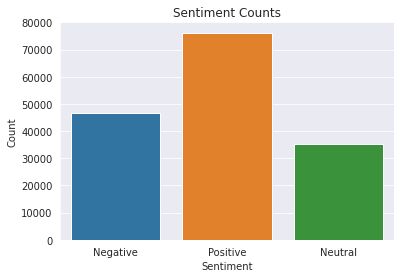

In [19]:
sns.set_style(style='darkgrid')
sns.countplot(x='sentiment', data=tweet_data)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Counts')
plt.show()

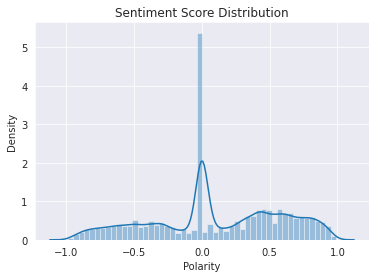

In [20]:
sns.distplot(tweet_data['sentiment_score'],hist=True)
plt.xlabel('Polarity')
plt.title('Sentiment Score Distribution')
plt.show()

In [21]:
likes_avg = pd.pivot_table(tweet_data,index='sentiment',values='likes',aggfunc='mean').reset_index()

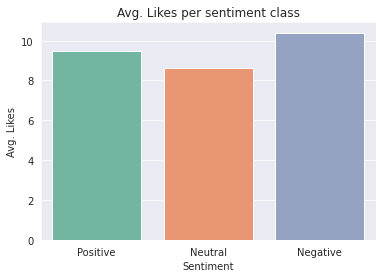

In [22]:
sns.barplot(x='sentiment', y='likes', data=likes_avg, order=['Positive','Neutral','Negative'], palette='Set2')
plt.xlabel('Sentiment')
plt.ylabel('Avg. Likes')
plt.title('Avg. Likes per sentiment class')
plt.show()

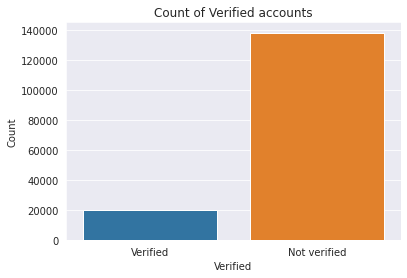

In [23]:
sns.countplot(x='verified', data=tweet_data)
plt.xlabel('Verified')
plt.ylabel('Count')
plt.title('Count of Verified accounts')
plt.show()

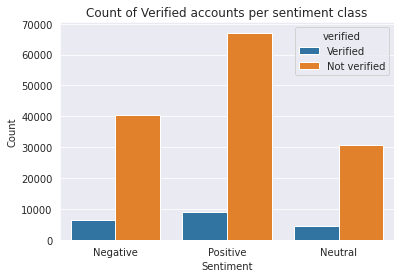

In [24]:
sns.countplot(x='sentiment', data=tweet_data, hue='verified')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Verified accounts per sentiment class')
plt.show()

### Frequent Terms

In [45]:
verified_positive_df = tweet_data[(tweet_data['verified']=='Verified') & (tweet_data['sentiment']=='Positive')]
verified_negative_df = tweet_data[(tweet_data['verified']=='Verified') & (tweet_data['sentiment']=='Negative')]
n_verified_positive_df = tweet_data[(tweet_data['verified']=='Not verified') & (tweet_data['sentiment']=='Positive')]
n_verified_negative_df = tweet_data[(tweet_data['verified']=='Not verified') & (tweet_data['sentiment']=='Negative')]

Text(0.5, 1.0, 'Positive Words - Verfied Accounts')

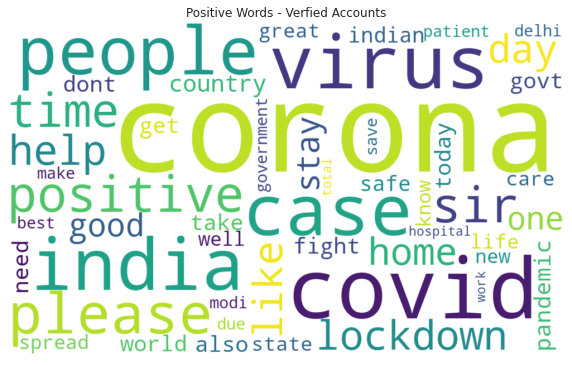

In [46]:
all_words = []
for x in verified_positive_df['processed_tweets']:
    all_words.extend(x)

fdist_text = FreqDist(all_words)

wc = WordCloud(width=1000, height=600, max_words=50, background_color="white").generate_from_frequencies(fdist_text)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Words - Verfied Accounts")

Text(0.5, 1.0, 'Negative Words - Verfied Accounts')

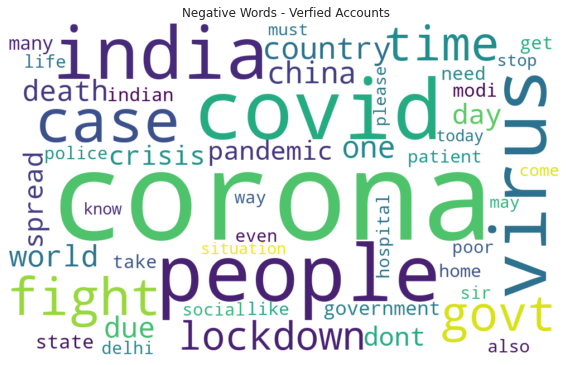

In [47]:
all_words = []
for x in verified_negative_df['processed_tweets']:
    all_words.extend(x)

fdist_text = FreqDist(all_words)

wc = WordCloud(width=1000, height=600, max_words=50, background_color="white").generate_from_frequencies(fdist_text)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Words - Verfied Accounts")

Text(0.5, 1.0, 'Positive Words - Non-Verfied Accounts')

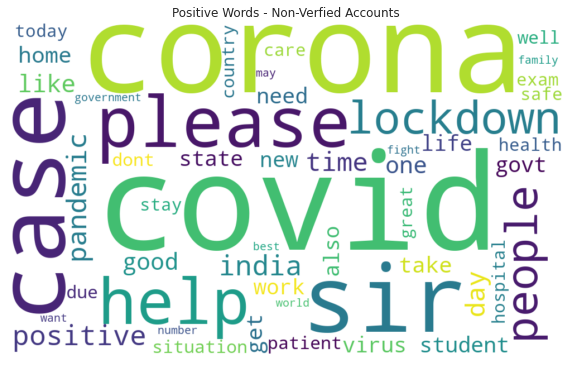

In [48]:
all_words = []
for x in n_verified_positive_df['processed_tweets']:
    all_words.extend(x)

fdist_text = FreqDist(all_words)

wc = WordCloud(width=1000, height=600, max_words=50, background_color="white").generate_from_frequencies(fdist_text)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Words - Non-Verfied Accounts")

Text(0.5, 1.0, 'Negative Words - Non-Verfied Accounts')

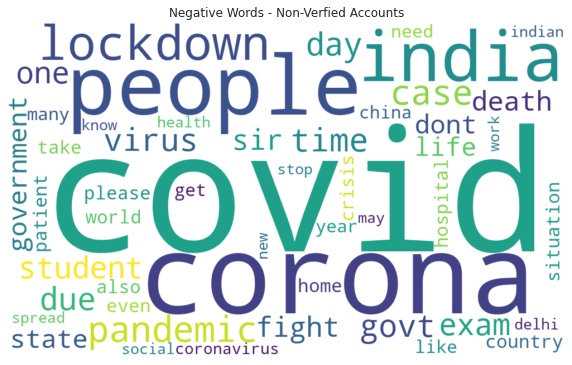

In [49]:
all_words = []
for x in n_verified_negative_df['processed_tweets']:
    all_words.extend(x)

fdist_text = FreqDist(all_words)

wc = WordCloud(width=1000, height=600, max_words=50, background_color="white").generate_from_frequencies(fdist_text)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Words - Non-Verfied Accounts")

### Top 20 Bigrams

In [50]:
Bigrams = []
for i,l in enumerate(tweet_data['processed_tweets']):
    bigrams_list = list(ngrams(l,2))
    bigrams = [' '.join(tup) for tup in bigrams_list]
    Bigrams.append(bigrams)

tweet_data['bigrams'] = Bigrams

Text(0.5, 1.0, 'Top 20 frequent bigrams')

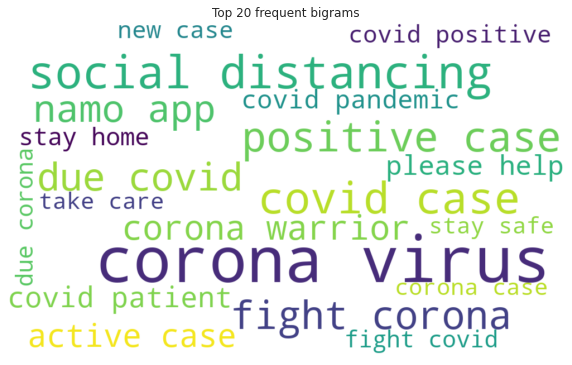

In [51]:
all_bigrams = []
for x in tweet_data['bigrams']:
    all_bigrams.extend(x)

fdist_bigrams = FreqDist(all_bigrams)

wc = WordCloud(width=1000, height=600, max_words=20, background_color="white").generate_from_frequencies(fdist_bigrams)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Top 20 frequent bigrams')

## LDA Topic Modeling

In [52]:
lda_token = []
for i,l in enumerate(tweet_data['processed_tweets']):
    lda_token.append([w for w in l if w not in ['corona','covid']])

tweet_data['lda_tokens'] = lda_token

In [53]:
id2word = Dictionary(tweet_data['lda_tokens'])
id2word.filter_extremes(no_below=2, no_above=.99)

In [54]:
corpus = [id2word.doc2bow(d) for d in tweet_data['lda_tokens']]

### Comparing Coherence values with no. of topics

In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, random_state=10, id2word=id2word, passes = 10, workers = 3)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic

In [56]:
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                                    corpus=corpus,
                                                                    texts=tweet_data['lda_tokens'],
                                                                    start=2, limit=40, step=2)

Text(0.5, 1.0, 'Coherence v/s Number of Topics')

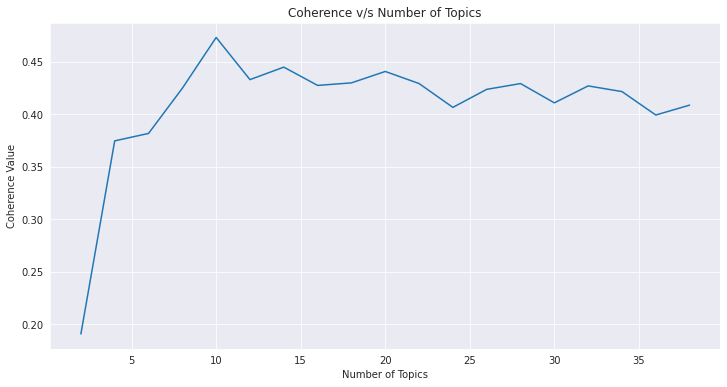

In [57]:
plt.figure(figsize=(12,6))
sns.lineplot(x=list(np.arange(2,40,2)),y=coherence_values_topic)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Value')
plt.title('Coherence v/s Number of Topics')

In [58]:
optimum_num_topics = input("Enter the optimum Number of topics:")

Enter the optimum Number of topics:20


In [59]:
lda_model_best = LdaMulticore(corpus,
                              num_topics=optimum_num_topics,
                              id2word = id2word,
                              random_state= 10,
                              passes = 10,
                              workers = 3)

In [60]:
print("Optimum No. of topics: ",optimum_num_topics)
best_perplexity = lda_model_best.log_perplexity(corpus)
print('\nBest Perplexity: ', best_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=lda_model_best, texts=tweet_data['lda_tokens'],dictionary=id2word, coherence='c_v')
coherence_lda_model_best = coherence_model.get_coherence()
print('Best Coherence Score: ', coherence_lda_model_best)

Optimum No. of topics:  20

Best Perplexity:  -8.348165654945591
Best Coherence Score:  0.4354741006861926


In [61]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_best, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19     0.013210 -0.084923       1        1  9.148387
17     0.089783 -0.175747       2        1  7.962593
12     0.181161 -0.002630       3        1  7.395054
0     -0.008356  0.330087       4        1  6.494987
16     0.152949  0.015645       5        1  5.769931
18    -0.167813 -0.020918       6        1  5.324992
8      0.055743 -0.044181       7        1  5.163940
14     0.151905  0.195393       8        1  4.921938
10     0.031443 -0.110352       9        1  4.636717
13    -0.219164 -0.014141      10        1  4.534818
9      0.067166 -0.095234      11        1  4.527109
15     0.103544  0.044828      12        1  4.398104
5      0.132807  0.062583      13        1  4.269707
3     -0.134603  0.089410      14        1  4.211595
2     -0.013215 -0.133195      15        1  3.845300
7     -0.094505 -0.125925      16        1  3.744069
1     -0.044555 -0.050671      17        1  3.741558
4     -0.212162  0.073843      18        1  3.479734
11    -0.093163  0.076741      19        1  3.429772
6      0.007824 -0.030614      20        1  2.999696, topic_info=          Term          Freq         Total Category  logprob  loglift
472       case  16799.000000  16799.000000  Default  30.0000  30.0000
79      please  10669.000000  10669.000000  Default  29.0000  29.0000
182        sir  12368.000000  12368.000000  Default  28.0000  28.0000
1322      exam   7296.000000   7296.000000  Default  27.0000  27.0000
452       help   8255.000000   8255.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2975       app    399.982293   3056.340450  Topic20  -4.9804   1.4731
390       must    366.525085   2656.741670  Topic20  -5.0678   1.5259
240       govt    416.112657   7670.975233  Topic20  -4.9409   0.5924
4577    senior    243.561232    501.389373  Topic20  -5.4765   2.7846
42    lockdown    268.511182  14901.013125  Topic20  -5.3790  -0.5096

[1210 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2150       9  0.995471      aaj
2561      11  0.996438      aap
16528     20  0.992595  aarogya
787       20  0.995324      abt
8721      20  0.994982     abvp
...      ...       ...      ...
2894      16  0.996861    youre
591       16  0.996266  youtube
12832      6  0.997754  zealand
2650       4  0.404252     zone
2650      13  0.594745     zone

[3008 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 18, 13, 1, 17, 19, 9, 15, 11, 14, 10, 16, 6, 4, 3, 8, 2, 5, 12, 7])

In [62]:
document_key = list(tweet_data.index) ##get index of transcripts for topic in each
document_topic = {}

for doc_id in range(len(corpus)):
    docbok = corpus[doc_id]
    doc_topics = lda_model_best.get_document_topics(docbok, 0)
    tmp = []
    for topic_id, topic_prob in doc_topics:
        tmp.append(topic_prob)
    document_topic[document_key[doc_id]] = tmp

# convert dictionnary of document-topic distritbutions to dataframe
df = pd.DataFrame.from_dict(document_topic, orient='index')

In [64]:
topic_column_names = ['topic_' + str(i+1) for i in range(0, int(optimum_num_topics))]
df.columns = topic_column_names

In [65]:
df['topic'] = df.idxmax(axis=1)
tweet_data['topic'] = df['topic']

In [66]:
from google.colab import files
tweet_data.to_csv('filename.csv') 
files.download('filename.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
topic_names = pd.read_csv('/content/drive/My Drive/tweet_data/topic_names.csv')

In [68]:
tweet_data_topics = pd.merge(tweet_data,topic_names,on='topic')

In [69]:
topic_counts = pd.pivot_table(tweet_data_topics,index='topic_name',values='text',aggfunc='count').sort_values(by='text',ascending=False).reset_index()

Text(0.5, 1.0, 'Topic Counts')

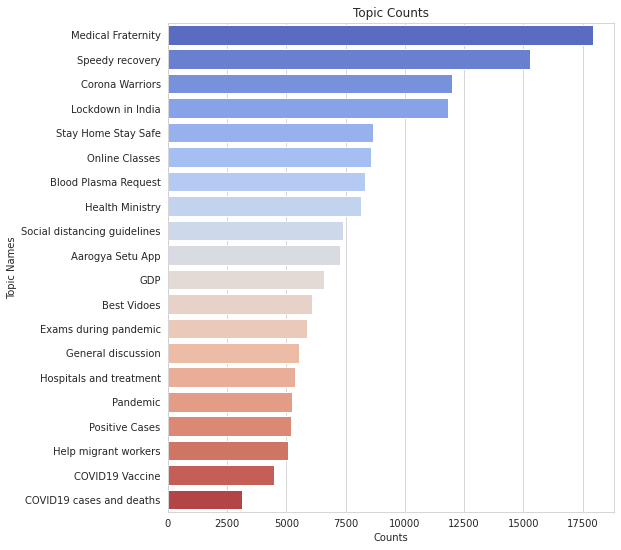

In [70]:
plt.figure(figsize=(8,9))
sns.set_style(style='whitegrid')
sns.barplot(x='text',y='topic_name',data=topic_counts,palette='coolwarm')
plt.xlabel('Counts')
plt.ylabel('Topic Names')
plt.title('Topic Counts')